# EDA on the DROP Dataset

#### Package installs

In [1]:
!pip install --quiet transformers
!pip install --quiet sentencepiece
!pip install --quiet wget
!pip install --quiet datasets
!pip install --quiet ipywidgets
!pip install --quiet tensorflow

You should consider upgrading via the '/home/omar/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/omar/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/omar/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/omar/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/omar/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/omar/miniconda3/bin/python -m pip install --upgrade pip' command.


#### check gpu

In [2]:
!nvidia-smi

Sun Aug  1 15:33:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P8    40W / 420W |  23094MiB / 24265MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Download allennlp drop_eval module

https://github.com/allenai/allennlp-reading-comprehension/blob/master/allennlp_rc/eval/drop_eval.py

In [3]:
!python -m wget https://raw.githubusercontent.com/allenai/allennlp-reading-comprehension/master/allennlp_rc/eval/drop_eval.py

100% [..........................................................] 11222 / 11222
Saved under drop_eval (1).py


#### set directories

In [4]:
!mkdir data

data_dir = "./data"
log_dir = f"{data_dir}/experiments/t5/logs"
save_path = f"{data_dir}/experiments/t5/models"
cache_path_train = f"{data_dir}/cache/t5.train"
cache_path_test = f"{data_dir}/cache/t5.test"

mkdir: cannot create directory ‘data’: File exists


#### load packages

In [15]:
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
import tensorflow as tf
import tensorflow.keras as keras
import drop_eval
import pandas as pd
import numpy as np
import json
from datasets import Dataset, load_dataset
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

#### Define model class

In [6]:
class T5forDrop(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss') 
    
    @tf.function
    def train_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)
            
            grads = tape.gradient(loss, self.trainable_variables)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)
        
        self.loss_tracker.update_state(loss)        
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}
    
    

def annot_barplot(df, x, title,y=None,figsize=(10,7)):
    fig,ax=plt.subplots(figsize=figsize)

    if not y:
        splot = sns.countplot(data=df, x=x)
    else:
        splot = sns.barplot(x=x,y=y)
        plt.xticks(rotation=90)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., 
                        p.get_height()), 
                       ha = 'center', 
                       va = 'center', 
                       xytext = (0, 10), 
                       textcoords = 'offset points')

    _=splot.set_title(title)
    plt.show()

#### Import model and tokenizer

#### Import data

In [7]:
train_dataset = load_dataset('drop', split='train')
valid_dataset = load_dataset('drop', split='validation')

train_dataset.features

Using custom data configuration default
Reusing dataset drop (/home/omar/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25)
Using custom data configuration default
Reusing dataset drop (/home/omar/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25)


{'section_id': Value(dtype='string', id=None),
 'query_id': Value(dtype='string', id=None),
 'passage': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'answers_spans': Sequence(feature={'spans': Value(dtype='string', id=None), 'types': Value(dtype='string', id=None)}, length=-1, id=None)}

In [8]:
def eda_encode(example):
    answer = example['answers_spans']['spans']
    answer_type = example['answers_spans']['types']
    outputs = {'answer':answer,'answer_type':answer_type}
    return outputs

Loading cached processed dataset at /home/omar/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25/cache-b8470e2d97f67f49.arrow



unique number of answer types per question:  [1]

Answer type counts:
number    46973
span      29195
date       1232
Name: answer_type, dtype: int64


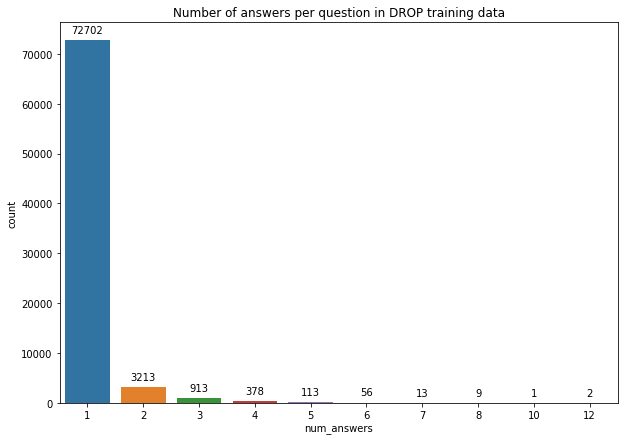

,section_id,query_id,passage,question,answers_spans,answer,answer_type_list,num_answers,answer_type_unique,num_unique_answers,answer_type,question_lower,question_strip
0,nfl_2201,f16c0ee7-f131-4a8b-a6ac-4d275ea68066,"To start the season, the Lions traveled south ...",How many points did the buccaneers need to tie...,"{'spans': ['3'], 'types': ['number']}",[3],[number],1,[number],1,number,how many points did the buccaneers need to tie...,how many points did buccaneers need tie in first?
1,nfl_2201,c9582e03-b01b-42ed-83e0-b90a5334aefa,"To start the season, the Lions traveled south ...",How many field goals did the Lions score?,"{'spans': ['2'], 'types': ['number']}",[2],[number],1,[number],1,number,how many field goals did the lions score?,how many field goals did lions score?
2,nfl_2201,f703d43d-73fa-4fda-8913-d81bd5569700,"To start the season, the Lions traveled south ...",How long was the Lion's longest field goal?,"{'spans': ['28-yard'], 'types': ['span']}",[28-yard],[span],1,[span],1,span,how long was the lion's longest field goal?,how long was lion's longest field goal?
3,nfl_2201,2fd4f473-af2b-44ce-929a-20c82fa6be2c,"To start the season, the Lions traveled south ...",Who caught the touchdown for the fewest yard?,"{'spans': ['Mike Williams'], 'types': ['span']}",[Mike Williams],[span],1,[span],1,span,who caught the touchdown for the fewest yard?,who caught touchdown for fewest yard?
4,nfl_2201,6592e06d-4ad6-484f-a9a5-5cb72c76dfee,"To start the season, the Lions traveled south ...",Who caught the shortest touchdown pass?,"{'spans': ['Calvin Johnson'], 'types': ['span']}",[Calvin Johnson],[span],1,[span],1,span,who caught the shortest touchdown pass?,who caught shortest touchdown pass?


In [11]:
train_df = train_dataset.map(eda_encode)
train_df = train_df.to_pandas()
train_df = train_df.rename(columns={'answer_type':'answer_type_list'})
train_df['num_answers'] = train_df.answer_type_list.str.len()
train_df['answer_type_unique'] = train_df.apply(lambda row: list(set(row['answer_type_list'])),axis=1)
train_df['num_unique_answers'] = train_df.answer_type_unique.str.len()

valid_df = valid_dataset.map(eda_encode)
valid_df = valid_df.to_pandas()
valid_df = valid_df.rename(columns={'answer_type':'answer_type_list'})
valid_df['num_answers'] = train_df.answer_type_list.str.len()
valid_df['answer_type_unique'] = valid_df.apply(lambda row: list(set(row['answer_type_list'])),axis=1)
valid_df['num_unique_answers'] = valid_df.answer_type_unique.str.len()


print('unique number of answer types per question: ', train_df.num_unique_answers.unique())

train_df['answer_type'] = train_df.apply(lambda row: row['answer_type_list'][0],axis=1)

print('\nAnswer type counts:')
print(train_df.answer_type.value_counts())

annot_barplot(train_df, x='num_answers', title='Number of answers per question in DROP training data')

train_df['question_lower'] = train_df.question.str.lower()
#remove stop words (add to list as needed!)
stop_words = ['the','of','to','and']
train_df['question_strip'] = train_df['question_lower'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))


train_df.head()

Analyzing only questions with answers of type "span"

span question vocab size: 174,281


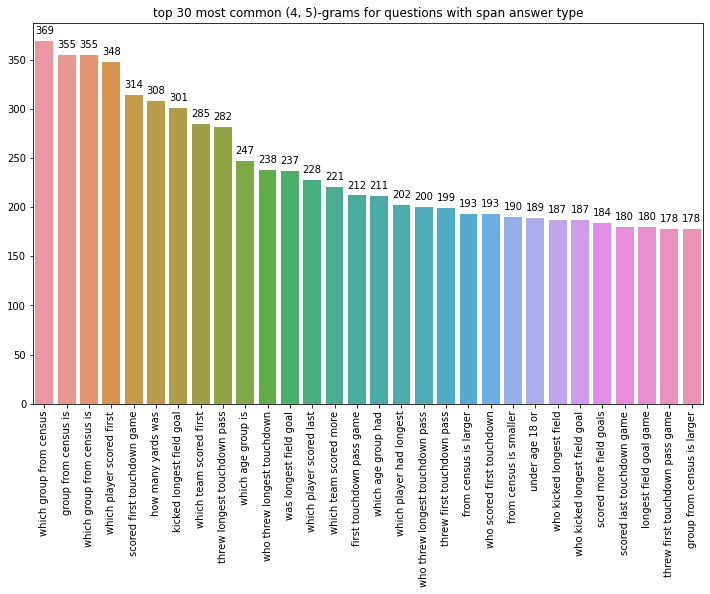




Analyzing only questions with answers of type "number"

number question vocab size: 328,237


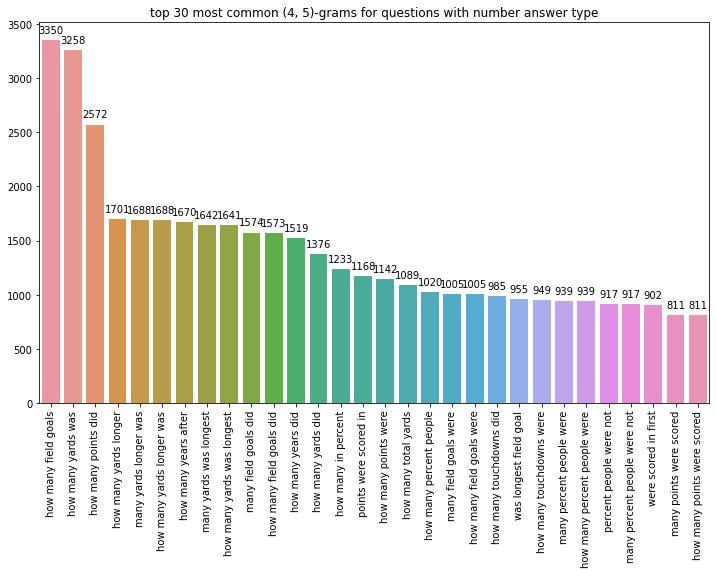




Analyzing only questions with answers of type "date"

date question vocab size: 12,237


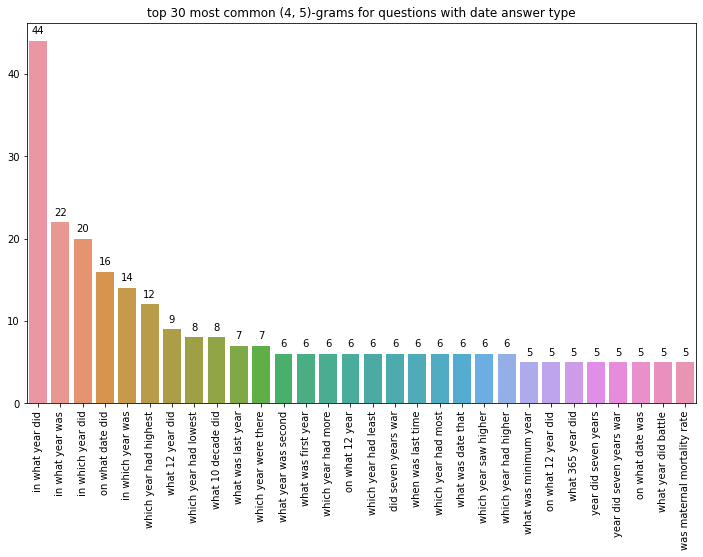

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

def bag_of_words_analysis(df, n=20, ans_type=None, ngram_range=(1,1),make_plot=True,figsize=(10,7)):


    if(ans_type != None):
        df=df[df.answer_type == ans_type]
        print(f'Analyzing only questions with answers of type "{ans_type}"\n')

    vectorizer = CountVectorizer(ngram_range=ngram_range)
    question_wordcount = vectorizer.fit_transform(df.question_strip)

    print('{} question vocab size: {:,}'.format(ans_type,len(vectorizer.get_feature_names())))

    sum_words = question_wordcount.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    if make_plot:
        words = [x[0] for x in words_freq[:n]]
        counts = [x[1] for x in words_freq[:n]]
        annot_barplot(df=None, 
                      x=words, 
                      title='top {} most common {}-grams for questions with {} answer type'.format(n,ngram_range,ans_type),
                      y=counts,
                      figsize=figsize)
    else:
        if ans_type: print(f'top {n} words in questions about {ans_type}s: ')
        else: print(f'top {n} words in all questions')
        print(words_freq[:n])
    print('\n\n')
    
    
ngram_range = (4,5)
figsize=(12,7)
bag_of_words_analysis(train_df,n=30,ans_type = 'span',ngram_range=ngram_range,figsize=figsize)
bag_of_words_analysis(train_df,n=30,ans_type = 'number',ngram_range=ngram_range,figsize=figsize)
bag_of_words_analysis(train_df,n=30,ans_type = 'date',ngram_range=ngram_range,figsize=figsize)


In [17]:
def tag_questions(df):

    df.reset_index(drop=True, inplace = True) #clean up - adding indicies
    
    df['answer_type'] = df.answers_spans.apply(lambda d: d['types'][0])

    df['answers_list'] = df.answers_spans.apply(lambda z: z['spans'])


    df['EasyQ'] = df.apply(lambda z: 1 if len(set(z['passage'].split()).intersection(set(z.answers_list))) > 0 else 0,axis=1)
    df['MathEasyQ'] = np.where((df.EasyQ == 1) &(df.answer_type == 'number'),1,0)
    df['MathHardQ'] = np.where((df.answer_type == 'number')&(df.MathEasyQ == 0),1,0)

    df['Or'] = np.where(df.question.str.contains(" or ", flags=re.IGNORECASE), 1, 0)
    
    sort_keywords = ["est ","first","last","more","less","better","worse","larger","smaller"]
    sort_pat = '|'.join(sort_keywords)
    df['Sort'] = np.where(df.question.str.contains(sort_pat,flags=re.IGNORECASE), 1, 0)
    df['Sort'] = np.where(df.question.str.match(r'[^\s]+er\b', flags=re.IGNORECASE), 1, df.Sort)
   
    df['check_tot'] = df[['Or','Sort','MathEasyQ','MathHardQ']].sum(axis=1)
    
    df['Or_Sort'] = df.apply(lambda z: 1 if z[['Or','Sort']].sum() == 2 else 0,axis=1)
    df['Or_Easy'] = df.apply(lambda z: 1 if z[['Or','MathEasyQ']].sum() == 2 else 0,axis=1)
    df['Or_Hard'] = df.apply(lambda z: 1 if z[['Or','MathHardQ']].sum() == 2 else 0,axis=1)
    df['Sort_Easy'] = df.apply(lambda z: 1 if z[['Sort','MathEasyQ']].sum() == 2 else 0,axis=1)
    df['Sort_Hard'] = df.apply(lambda z: 1 if z[['Sort','MathHardQ']].sum() == 2 else 0,axis=1)
    df['Or_Sort_Easy'] = df.apply(lambda z: 1 if z[['Or','MathEasyQ', 'Sort']].sum() == 3 else 0,axis=1)
    df['Or_Sort_Hard'] = df.apply(lambda z: 1 if z[['Or','MathHardQ', 'Sort']].sum() == 3 else 0,axis=1)
    
    q_list = ['Or','Sort','MathEasyQ','MathHardQ', 'Or_Sort', 'Or_Easy', 'Or_Hard', 'Sort_Easy', 'Sort_Hard', 'Or_Sort_Easy', 'Or_Sort_Hard' ]
    a_list = ['span','number','date']
    return df


def print_example(query_id,df):
    print('question: ',df.loc[df.query_id == query_id,'question'].iloc[0])
    print('passage: ',df.loc[df.query_id == query_id,'passage'].iloc[0])
    print('\npredicted answer: ',df.loc[df.query_id == query_id,'predicted'].iloc[0])
    print('True answers: ',df.loc[df.query_id == query_id,'answers_spans'].iloc[0])
    print('F1 score: ',df.loc[df.query_id == query_id,'F1'].iloc[0])
    print('EM score: ',df.loc[df.query_id == query_id,'EM'].iloc[0])

In [18]:
df = tag_questions(valid_df)

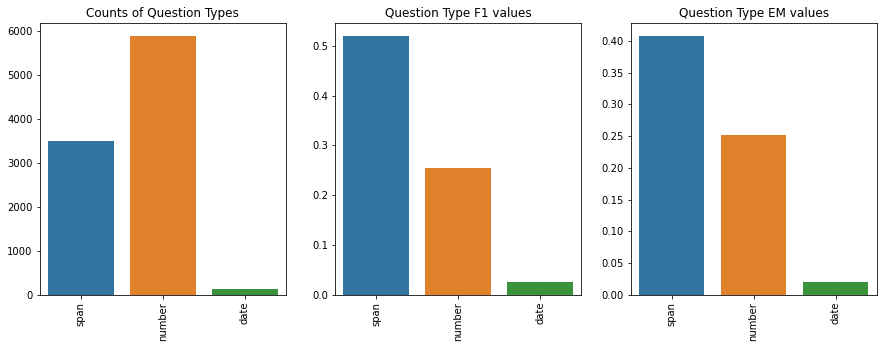

In [11]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))

ax[0] = sns.barplot(x=a_list,y=all_count,ax=ax[0])
_=ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
_=ax[0].set_title('Counts of Question Types')

ax[1] = sns.barplot(x=a_list,y=all_F1,ax=ax[1])
_=ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
_=ax[1].set_title('Question Type F1 values')

ax[2] = sns.barplot(x=a_list,y=all_EM,ax=ax[2])
_=ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=90)
_=ax[2].set_title('Question Type EM values')

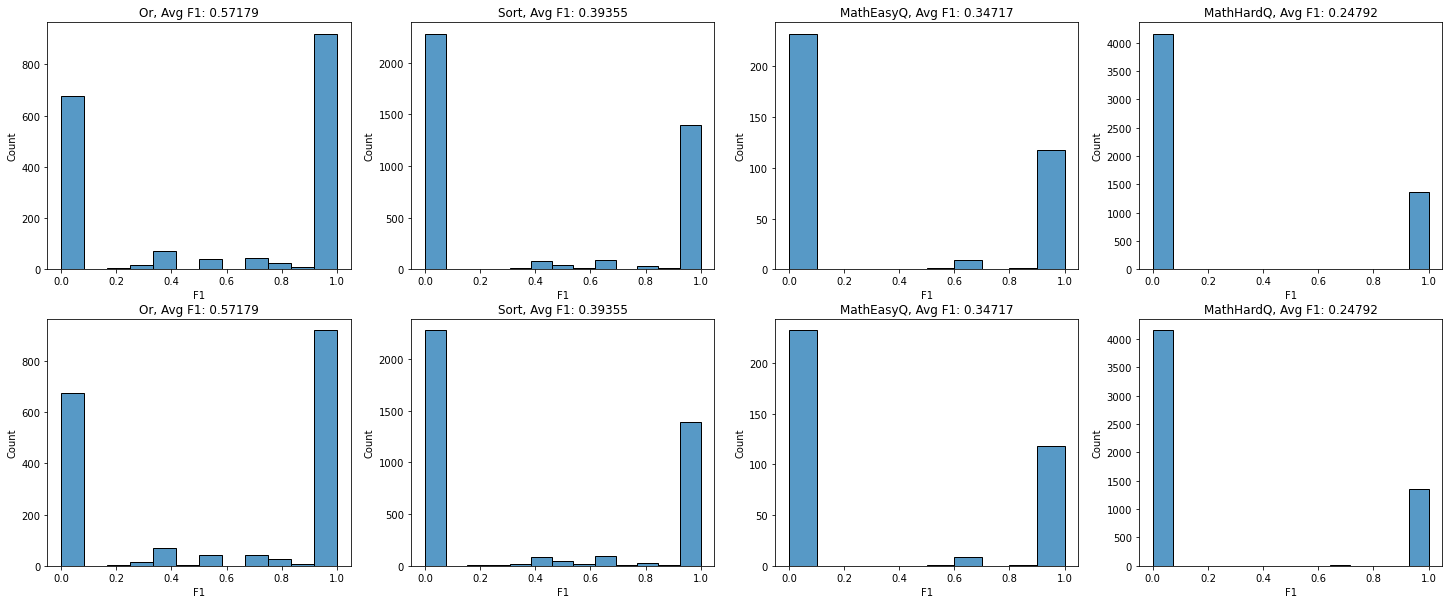

In [14]:
nrows = 2
ncols = 4
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(25,10))
for row in range(nrows):
    counter = 0
    for col in range(ncols):
        ax[row,col] = sns.histplot(data=df[df[q_list[counter]]==1],x='F1',label=q_list[counter],ax=ax[row,col])
        ax[row,col].set_title(f'{q_list[counter]}, Avg F1: {df[df[q_list[counter]] == 1].F1.mean():0.5f}')
        counter = counter + 1
    

## Hard Examples

In [23]:
df[(df.MathHardQ == 1)&(df.Or == 0)&(df.Sort == 0)].sample(5)

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,check_tot,Or + Sort,Or + Easy,Or + Hard,Sort + Easy,Sort + Hard,Or + Sort + Easy,Or + Sort + Hard
5706,nfl_663,8376b1d5-6acc-406a-a8ff-5718f4aba983,Still looking for their first win of the year...,How many touchdowns total were scored in the f...,"{'spans': ['3', '3'], 'types': ['number', 'num...",3,1.0,1.0,number,"[3, 3]",0,0,1,0,0,1,0,0,0,0,0,0,0
3344,history_1151,eaa88ab7-e8f6-4038-8918-c9a13d6c5256,The Conference of Ambassadors drew the first d...,How many days after Foch's proposal was it app...,"{'spans': ['8'], 'types': ['number']}",2,0.0,0.0,number,[8],0,0,1,0,0,1,0,0,0,0,0,0,0
8850,history_3278,091f779c-00ad-419b-87aa-270a1535d3be,"Per 2013 census, the total population of the d...",How many percent of the foreign population was...,"{'spans': ['73.6', '73.6'], 'types': ['number'...",73.6,1.0,1.0,number,"[73.6, 73.6]",0,0,1,0,0,1,0,0,0,0,0,0,0
4900,nfl_477,bdfb3968-f1e0-43a1-9fae-e6a9c2e67dcf,Hoping to rebound from a last-second home los...,how many yards did lindell nail,"{'spans': ['24', '24'], 'types': ['number', 'n...",24,1.0,1.0,number,"[24, 24]",0,0,1,0,0,1,0,0,0,0,0,0,0
7840,history_2976,f3c683cb-d900-47fa-93a5-5b927a9fb79c,"According to the Canada 2011 Census, the large...",How many percent were not French?,"{'spans': ['87.8', '87.8'], 'types': ['number'...",81.4,0.0,0.0,number,"[87.8, 87.8]",0,0,1,0,0,1,0,0,0,0,0,0,0


In [16]:
ids = ['ac6ba235-3024-4f63-a6ab-730a14def4cb', 'bb96ca91-0c34-420d-85d3-ef723e8b8853']

In [17]:
print_example('ac6ba235-3024-4f63-a6ab-730a14def4cb', df)

question:  How many field goals did Kris Brown kick?
passage:   Hoping to rebound from their loss to the Patriots, the Raiders stayed at home for a Week 16 duel with the Houston Texans.  Oakland would get the early lead in the first quarter as quarterback JaMarcus Russell completed a 20-yard touchdown pass to rookie wide receiver Chaz Schilens.  The Texans would respond with fullback Vonta Leach getting a 1-yard touchdown run, yet the Raiders would answer with kicker Sebastian Janikowski getting a 33-yard and a 30-yard field goal.  Houston would tie the game in the second quarter with kicker Kris Brown getting a 53-yard and a 24-yard field goal. Oakland would take the lead in the third quarter with wide receiver Johnnie Lee Higgins catching a 29-yard touchdown pass from Russell, followed up by an 80-yard punt return for a touchdown.  The Texans tried to rally in the fourth quarter as Brown nailed a 40-yard field goal, yet the Raiders' defense would shut down any possible attempt.

pred

In [18]:
print_example('bb96ca91-0c34-420d-85d3-ef723e8b8853', df)

question:  How many points were scored in total in the 1st half?
passage:   After a tough loss at home, the Bengals would remain at home for a game against the Bears.  In the first quarter, the Bears took an early lead when Jordan Howard ran for a 21-yard touchdown (with a failed PAT) to make it 6-0.  The Bengals however took the lead later on in the quarter when Andy Dalton found Brandon LaFell on a 14-yard pass to make it 7-6.  The Bears retook the lead in the second quarter when Mike Nugent kicked 2 field goals:  From 34 and 27 yards out to make it 9-7 and then 12-7 at halftime.  The Bears then shut out the Bengals the entire second half while they score themselves:  In the third quarter Mitchell Trubisky ran for a 4-yard touchdown to make it 19-7 for the only score of the third quarter.  In the fourth quarter, they wrapped up the scoring when Trubisky found Adam Shaheen on a 1-yard pass to make it 26-7.  Howard then ran for an 8-yard touchdown to make the final score 33-7. With the

In [21]:
print_example('3bdedbf5-1856-438f-9f79-26f3ce4501a4', df)

question:  How many fewer robberies were reported to the New York City Police Department in 2010 than in 2000?
passage:  With the end of the "crack epidemic" in the mid-1990s and with the initiation of aggressive policing under mayors David Dinkins and subsequently  Rudolph Giuliani, crime in Harlem plummeted. In 1981, 6,500 robberies were reported in Harlem; robberies dropped to 4,800 in 1990 during David Dinkins mayoralty. By 2000, only 1,700 robberies were reported, and by 2010, only 1,100 were reported. There have been similar changes in all categories of crimes tracked by the New York City Police Department. In the 32nd Precinct, which services Central Harlem above 127th Street, for example, between 1990 and 2013, the murder rate dropped 89.4%, the rape rate dropped 67.5%, the robbery rate dropped 74.2%, burglary dropped 93.4%, and the total number of crime complaints dropped 77.6%.

predicted answer:  10 00
True answers:  {'spans': array(['600', '600'], dtype=object), 'types': ar

In [24]:
print_example('eaa88ab7-e8f6-4038-8918-c9a13d6c5256', df)

question:  How many days after Foch's proposal was it approved by the Entente?
passage:  The Conference of Ambassadors drew the first demarcation line on June 18. The line, drawn about 5 km  west of the Warsaw - Saint Petersburg Railway, was based on the military situation on the ground rather than ethnic composition. Neither Poles nor Lithuanians were content with the line. The Polish Ministry of Foreign Affairs rejected the line as it would require the Polish forces to retreat up to 35 km . The Lithuanians protested leaving Vilnius and Hrodna under Polish control. As German volunteers were departing from Lithuania and Lithuanian forces were preoccupied with battles against the Soviets in northern Lithuania, Poland mounted an offensive on 100 km  wide front moving 20-30 km  deeper into the Lithuanian territory. On July 18, Ferdinand Foch proposed the second demarcation line, known as the Foch Line. It was approved by the Entente on July 26. The Lithuanians were informed about the new 

## Hard + Sort Examples

In [58]:
df[(df.MathHardQ == 1)&(df.Or == 0)&(df.Sort == 1)].sample(5)

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,check_tot,Or + Sort,Or + Easy,Or + Hard,Sort + Easy,Sort + Hard,Or + Sort + Easy,Or + Sort + Hard
4634,history_107,1e81fe2c-cb65-40a1-85e1-cf6e57cb25a2,Knopf was founded in 1915 by Alfred A. Knopf S...,How many years transpired between when Knopp's...,"{'spans': ['2', '2'], 'types': ['number', 'num...",2,1.0,1.0,number,"[2, 2]",0,0,1,0,1,2,0,0,0,0,1,0,0
3303,nfl_624,b913af81-d912-40d3-8795-ed00c4ea6e49,Coming off their impressive home win over the...,How many yards more was the longest field goal...,"{'spans': ['6', '6', '6', '6'], 'types': ['num...",10,0.0,0.0,number,"[6, 6, 6, 6]",0,0,1,0,1,2,0,0,0,0,1,0,0
8460,history_2765,5348da98-9ab3-46d0-9b26-a4123386db1d,"As of 2011 the 88,112 residents of Orem had a ...","How many more people, in terms of percentage, ...","{'spans': ['88.8', '88.8'], 'types': ['number'...",10.3,0.0,0.0,number,"[88.8, 88.8]",0,0,1,0,1,2,0,0,0,0,1,0,0
4230,history_296,801ec5ad-dacb-4cb1-b0f9-460dc018eef7,The Byzantine civil war of 1373-1379 was a mil...,How many years did the Byzantine civil war last?,"{'spans': ['6', '6'], 'types': ['number', 'num...",2,0.0,0.0,number,"[6, 6]",0,0,1,0,1,2,0,0,0,0,1,0,0
4399,nfl_290,bd052c0c-9c65-4a4d-9262-b83e5a2f81d3,"For the third straight week, the game got off...",How many yards was the second longest touchdow...,"{'spans': ['4', '6'], 'types': ['number', 'num...",13,0.0,0.0,number,"[4, 6]",0,0,1,0,1,2,0,0,0,0,1,0,0


In [ ]:
#really tough MATH & SORT question!!
print_example('c94cef85-f269-43cf-8279-14892239dedf',df)

#another tough MATH SORT
print_example('e2514a1c-07d1-49dc-b987-0dd832b5bd52',df)

ids = ['c94cef85-f269-43cf-8279-14892239dedf', 'e2514a1c-07d1-49dc-b987-0dd832b5bd52', 'bcf578c2-0271-4f54-b980-cb438b34df2d', '29b34c2b-89ad-4697-bdfc-5cee4e64830e', '29b34c2b-89ad-4697-bdfc-5cee4e64830e']

## Hard + Or Examples

In [41]:
df[(df.MathHardQ == 1)&(df.Or == 1)&(df.Sort == 0)].sample(5)

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,check_tot,Or + Sort,Or + Easy,Or + Hard,Sort + Easy,Sort + Hard,Or + Sort + Easy,Or + Sort + Hard
761,history_1863,e344e703-943a-4461-b758-0e75482aafbf,"As of the census of 2000, there were 24,621 pe...","How many people, in terms of percentage, were ...","{'spans': ['1.95'], 'types': ['number']}",3.1,0.0,0.0,number,[1.95],0,0,1,1,0,2,0,0,1,0,0,0,0
5598,history_2064,36b5bbd6-a873-4bd8-92d9-287e4b0ad78e,"In 1984, the 49ers had one of the greatest sea...",How many times was the record for most regular...,"{'spans': ['5', '4'], 'types': ['number', 'num...",2,0.0,0.0,number,"[5, 4]",0,0,1,1,0,2,0,0,1,0,0,0,0
5109,history_2151,87b641ca-41de-4398-9371-91451ced051f,"In the county, the population was spread out w...",How many in percent weren't 65 years of age or...,"{'spans': ['85.4', '85.4'], 'types': ['number'...",85.4,1.0,1.0,number,"[85.4, 85.4]",0,0,1,1,0,2,0,0,1,0,0,0,0
2908,history_1954,7af25553-830e-4dc5-a406-5031ecc79150,"As of the census of 2000, there were 19,234 pe...","How many people, in terms of percentage, were ...","{'spans': ['13.09', '13.09'], 'types': ['numbe...",12.71,0.0,0.0,number,"[13.09, 13.09]",0,0,1,1,0,2,0,0,1,0,0,0,0
9206,history_2953,4029aace-b57a-4e15-9b00-d865bd94a0ec,"German has 13,444 speakers representing about ...","How many people speak either German, Vietnames...","{'spans': ['40245', '40245'], 'types': ['numbe...",13 44 4,0.0,0.0,number,"[40245, 40245]",0,0,1,1,0,2,0,0,1,0,0,0,0


## Sort Examples

In [27]:
df[(df.MathHardQ == 0)&(df.Or == 0)&(df.Sort == 1)].sample(5)

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,check_tot,Or + Sort,Or + Easy,Or + Hard,Sort + Easy,Sort + Hard,Or + Sort + Easy,Or + Sort + Hard
3794,history_1891,084d9915-4af4-429e-9b30-002ebc62cc58,The 2010 United States Census reported that Hu...,What two ethnic groups had the highest populat...,"{'spans': ['White', 'Asian', 'White', 'Asian']...","White, African American",0.0,0.5,span,"[White, Asian, White, Asian]",1,0,0,0,1,1,0,0,0,0,0,0,0
8168,history_3608,6ba1c8f7-435b-419f-a8b6-0b7d11e158e7,Modern Clallam County is generally regarded as...,Which candidate got more of the vote than any ...,"{'spans': ['George W. Bush', 'George W. Bush']...",Barack Obama,0.0,0.0,span,"[George W. Bush, George W. Bush]",0,0,0,0,1,1,0,0,0,0,0,0,0
3466,nfl_2369,aad77009-c159-4266-8e15-11ce5e9775ac,Coming off their miraculous comeback in San D...,Who threw the first touchdown pass of the game?,"{'spans': ['Drew Brees', 'Drew Brees'], 'types...",Drew Brees,1.0,1.0,span,"[Drew Brees, Drew Brees]",0,0,0,0,1,1,0,0,0,0,0,0,0
8793,history_2829,9fc8e12b-fe92-4de1-b841-5be50f2e1df8,The Pistons opened the 2007 NBA Playoffs with ...,Which of the Pistons' games against the Bulls ...,"{'spans': ['Game 3', 'Game 3'], 'types': ['spa...",Game4,0.0,0.0,span,"[Game 3, Game 3]",0,0,0,0,1,1,0,0,0,0,0,0,0
7893,history_2857,0b0e301a-7c02-484d-a9d8-eb7567cdd3a1,"In the county, the population is spread out wi...",Which groups in percent are larger than 21%?,"{'spans': ['under the age of 18', '25 to 44', ...","under the age of18,25 to44,45 to6",0.0,0.0,span,"[under the age of 18, 25 to 44, 45 to 64, unde...",0,0,0,0,1,1,0,0,0,0,0,0,0


In [25]:
print_example('dc48b619-5890-4ce1-9820-7fd2adab4388', df)

question:  What was the largest ancesitry identified in the city?
passage:  In the census of 2010, there were 66,135 people, 26,265 (2000 data) households, and 14,051 (2000 data) families residing in the city. The population density was 6,096.7 people per square mile (2,199.9/km²). There were 30,272 (2000 data) housing units at an average density of 2,790.6 per square mile (1,077.2/km²). The racial makeup of the city was 59.38% (52.31% Non-Hispanic) (7.07 White-Hispanic) White (U.S. Census), 24.19% African American (U.S. Census), 14.47% Hispanic (U.S. Census) or Latin (U.S. Census)) of any race, 8.24% from Race (United States Census), 5.74% from two or more races, 2.62% Asian (U.S. Census), 0.69%  Native American (U.S.Census), and 0.14% Pacific Islander (U.S. Census). There is a growing Guyana population in the area. The top ancestries self-identified by people on the census are Italian (13.6%), Guyanese (12.3%), Irish (12.1%), Puerto Rican (10.1%), German (8.7%), English (6.0%), Polis

In [26]:
print_example('29524a49-d20f-4b58-b7c9-7ffee84e9ca5', df)

question:  How many yards was the shortest touchdown pass?
passage:   Hoping to snap a two-game losing streak, the Falcons went home for a Week 9 duel with the Washington Redskins.  Atlanta would take flight in the first quarter as quarterback Matt Ryan completed a 2-yard touchdown pass to tight end Tony Gonzalez, followed by cornerback Tye Hill returning an interception 62 yards for a touchdown.  The Redskins would answer in the second quarter as kicker Shaun Suisham nailed a 48-yard field goal, yet the Falcons kept their attack on as running back Michael Turner got a 30-yard touchdown run, followed by kicker Jason Elam booting a 33-yard field goal. Washington began to rally in the third quarter with a 1-yard touchdown run from running back Ladell Betts.  The Redskins would come closer in the fourth quarter as quarterback Jason Campbell hooked up with tight end Todd Yoder on a 3-yard touchdown pass, yet Atlanta closed out the game with Turner's 58-yard touchdown run.

predicted answer

In [28]:
print_example('084d9915-4af4-429e-9b30-002ebc62cc58', df)

question:  What two ethnic groups had the highest populations in Huntington Beach in 2010?
passage:  The 2010 United States Census reported that Huntington Beach had a population of 189,992. The population density was 5,959.1 people per square mile (2,300.8/km²). The racial makeup of Huntington Beach was 145,661 (76.7%) White (U.S. Census), 1,813 (1.0%) African American (U.S. Census), 992 (0.5%) Native American (U.S. Census), 21,070 (11.1%) Asian (U.S. Census), 635 (0.3%) Pacific Islander (U.S. Census), 11,193 (5.9%) from Race (United States Census), and 8,628 (4.5%) from two or more races. Hispanic (U.S. Census) or Latino (U.S. Census) of any race were 32,411 persons (17.1%). Non-Hispanic Whites were 67.2% of the population in 2010, compared to 90.8% in 1970.

predicted answer:  White, African American
True answers:  {'spans': array(['White', 'Asian', 'White', 'Asian'], dtype=object), 'types': array(['span', 'span', 'span', 'span'], dtype=object)}
F1 score:  0.5
EM score:  0.0


## Sort + Or Examples

In [ ]:
ids = ['f6fc8e67-5aa2-4a04-b65e-05a154bcc1ae', 'e08a599f-39cc-4d28-8092-1ccaf367247d', ]

In [43]:
df[(df.MathHardQ == 0)&(df.Or == 1)&(df.Sort == 1)].sample(5)

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,check_tot,Or + Sort,Or + Easy,Or + Hard,Sort + Easy,Sort + Hard,Or + Sort + Easy,Or + Sort + Hard
6101,history_2196,fa780708-3025-423a-a7c6-0c12274106a2,"As of 2000, there were 19,306 households out o...",Which group for households is smaller: married...,"{'spans': ['non-families', 'non-families'], 't...",non-families,1.0,1.0,span,"[non-families, non-families]",0,0,0,1,1,2,1,0,0,0,0,0,0
3399,history_200,c289ee49-4d4f-4819-ba7b-ed6bb70000bf,"Charles reached Rome in 1265, but was temporar...",Which battle in Charles cavalry had two hundre...,"{'spans': ['the second'], 'types': ['span']}",the third battle,0.0,0.0,span,[the second],0,0,0,1,1,2,1,0,0,0,0,0,0
2083,history_787,78431f25-75f8-4db8-877a-0a8436784321,"In literature, apart from Scott's Waverley nov...","Which was produced first, Bonnie Prince Charli...","{'spans': ['Bonnie Prince Charlie', 'Bonnie Pr...",Bonnie Prince Charlie,1.0,1.0,span,"[Bonnie Prince Charlie, Bonnie Prince Charlie]",0,0,0,1,1,2,1,0,0,0,0,0,0
7431,history_2474,dbf1cb90-7c9d-4a50-b67e-913164806927,Montana finished the regular season with 238 c...,Who finished the NFL with the 49ers with more ...,"{'spans': ['Montana', 'Montana'], 'types': ['s...",Montana,1.0,1.0,span,"[Montana, Montana]",1,0,0,1,1,2,1,0,0,0,0,0,0
930,history_124,b19dc021-b39d-46a2-a7b7-c5dcfd6dfe8a,After twelve years of peace following the Indi...,What happened first: Indian Wars or Anglo-Powh...,"{'spans': ['Indian Wars', 'Indian Wars'], 'typ...",Indian Wars,1.0,1.0,span,"[Indian Wars, Indian Wars]",0,0,0,1,1,2,1,0,0,0,0,0,0


## Or Examples

In [34]:
df[(df.MathHardQ == 0)&(df.Or == 1)&(df.Sort == 0)].sample(5)

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,check_tot,Or + Sort,Or + Easy,Or + Hard,Sort + Easy,Sort + Hard,Or + Sort + Easy,Or + Sort + Hard
9184,history_3866,ccf4c05b-6295-4671-9f40-473f53a16bd0,"By 2007, 56.8% of evacuees had found jobs, 22....",Who had higher salaries before the disengageme...,"{'spans': ['the general population', 'evacuees...",evacuess,0.0,0.0,span,"[the general population, evacuees]",1,0,0,1,0,1,0,0,0,0,0,0,0
3771,history_1891,28e247e2-f9b5-4c59-8395-08b680c95f1d,The 2010 United States Census reported that Hu...,What race had a higher population on the 2010 ...,"{'spans': ['African American', 'African Americ...",African American,1.0,1.0,span,"[African American, African American, African A...",0,0,0,1,0,1,0,0,0,0,0,0,0
3560,history_325,c82ee21b-2d27-4945-8aca-5a3a66d64dc1,"Lévis returned to France on parole, and was re...",What happened second: promoted to Marshal of F...,"{'spans': ['inheritable title Duc de Lévis', '...",inheritable title Duc de Lévis,1.0,1.0,span,"[inheritable title Duc de Lévis, inheritable t...",0,0,0,1,0,1,0,0,0,0,0,0,0
8745,history_2642,4d4904d2-feb1-4c27-9623-3778880c0c7a,"Like most other European countries, Hungary is...",Was life expectancy longer for men or women?,"{'spans': ['women', 'women'], 'types': ['span'...",men,0.0,0.0,span,"[women, women]",1,0,0,1,0,1,0,0,0,0,0,0,0
1785,history_2102,88cf5a53-590f-4f7a-8439-6f7a22dc6139,"After being higher in the postwar period, the ...","In 1955, did fewer Americans work in services ...","{'spans': ['agriculture', 'Agriculture', 'Agri...",agriculture,1.0,1.0,span,"[agriculture, Agriculture, Agriculture, Agricu...",1,0,0,1,0,1,0,0,0,0,0,0,0


In [33]:
print_example('6a1259c1-5a0a-4ca1-b189-7964b0524ae9', df)

question:  Was the population higher pre-war or post-war?
passage:  The Treaty of Karlowitz, signed in January 1699, confirmed the Venetian possession of Kephalonia, and the Morea with the island of Aigina, which became organized as the "Kingdom of the Morea" , divided into four provinces: Romania, with seat at Nafplion , Laconia, with seat at Monemvasia , Messenia, with seat at Navarino, and Achaea, with seat at Patras . The war however had created a demographic and economic crisis in the Peloponnese. According to the first census conducted by the Venetians, there were 86,468 people in the peninsula compared to a pre-war population of around 200,000. Although the Venetians managed to restore some prosperity - the population allegedly rose to some 250,000 by 1708, probably driven by immigration - they failed to win the trust of their Greek Orthodox subjects, who were used to a relative autonomy under the Turks and resented the Venetian bureaucracy. The Venetians also launched a great f

In [32]:
print_example('1fbaf92a-c631-4081-96ad-480d01278bfe', df)

question:  How many in percent weren't 65 years of age or older?
passage:  In the city, the population was distributed as 28.3% under the age of 18, 11.3% from 18 to 24, 32.7% from 25 to 44, 18.2% from 45 to 64, and 9.6% who were 65 years of age or older. The median age was 31 years. For every 100 females, there were 97.3 males. For every 100 females age 18 and over, there were 94.5 males.

predicted answer:  90.4
True answers:  {'spans': array(['90.4', '90.4'], dtype=object), 'types': array(['span', 'number'], dtype=object)}
F1 score:  1.0
EM score:  1.0


In [31]:
print_example('f55a7690-17dc-4e98-8457-47b80c51d530', df)

question:  Which of these is NOT a leading cause of death in Texas, stroke, hypertension, cancer, or heart disease?
passage:  Consequences of obesity  Obesity causes several chronic diseases including heart disease and diabetes. The three leading causes of death in Texas - heart disease, stroke, and cancer - are all linked to obesity. Additionally, obesity can cause type 2 diabetes, arteriosclerosis, and hypertension. In 2010, Texas saw 1,261,654 cases of heart disease and is predicted to see 5,688,482 cases in 2030. In 2010, Texas saw 1,962,059 cases of diabetes and is predicted to see 2,851,697 cases in 2030. In 2010, Texas saw 4,300,252 cases of hypertension and is predicted to see 5,689,509 cases in 2030. In 2010, Texas saw 328,379 cases of obesity-related cancer and is predicted to see 810,806 cases in 2030.

predicted answer:  heart disease, stroke, cancer
True answers:  {'spans': array(['hypertension', 'hypertension', 'hypertension'], dtype=object), 'types': array(['span', 'span

## Hard + Sort + Or Examples

In [57]:
df[(df.MathHardQ == 1)&(df.Or == 1)&(df.Sort == 1)].sample(5)

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,check_tot,Or + Sort,Or + Easy,Or + Hard,Sort + Easy,Sort + Hard,Or + Sort + Easy,Or + Sort + Hard
862,history_2170,d2ebed8f-9e26-4d77-a5fd-8afa49779a34,"In the census of 2010, there were 66,135 peopl...",Did more people self-identify with a German or...,"{'spans': ['20.8', 'irish'], 'types': ['number...",German,0.0,0.00,number,"[20.8, irish]",0,0,1,1,1,3,1,0,1,0,1,0,1
6087,history_2196,065bce67-40b3-4898-932b-5fbc922225a8,"As of 2000, there were 19,306 households out o...","As of 2000, which group for households is larg...","{'spans': ['.54', 'average family size'], 'typ...",average household size,0.0,0.67,number,"[.54, average family size]",0,0,1,1,1,3,1,0,1,0,1,0,1
1171,history_951,bd03c841-ac96-464d-8d85-dfcaffefcee1,"According to official records, the British gov...",How many more troops were improsned than the t...,"{'spans': ['45235', '41415'], 'types': ['numbe...",13 33,0.0,0.00,number,"[45235, 41415]",0,0,1,1,1,3,1,0,1,0,1,0,1
1775,history_2102,8bc4b5a0-efed-42c1-930d-d0aca5478ea1,"After being higher in the postwar period, the ...",Did more Americans work in services in 1980 or...,"{'spans': ['1980', '1980'], 'types': ['number'...",19 80,0.0,0.00,number,"[1980, 1980]",0,0,1,1,1,3,1,0,1,0,1,0,1
9438,history_4011,b3b9d628-b629-4bcf-8df6-ebe6a19505d2,", those of African ancestry accounted for 19.2...",How many more percent of people were Haitian c...,"{'spans': ['3.2', '3.6'], 'types': ['number', ...",1.4,0.0,0.00,number,"[3.2, 3.6]",0,0,1,1,1,3,1,0,1,0,1,0,1
